### 1. Raman spectroscopy

In [315]:
# import library
import numpy as np
import scipy as sci
from scipy.signal import find_peaks
from scipy.interpolate import splev, splrep, sproot
import matplotlib.pyplot as plt

# load raman.txt
file_path = '/Users/woojaejeong/Desktop/Program/USC/Computational Introduction to Deep Learning/Homeworks/HW2/raman.txt'

data_array = np.loadtxt(file_path)

wavenumber = data_array[:,0]    # Save wavenumber
intensity = data_array[:,1]     # Save intensity

# Detect initial peaks from the raw intensity 
peaks,_ = find_peaks(intensity, distance = 20)

# Define peak detection
def peak_detection(wavenumber, intensity, peaks):
    
    i_raw = []; w_raw = []; i_inter = []; w_inter = []; z_cross = []; i_inter_max = []; w_inter_max = []

    for n in range(len(peaks)):
        # Set ROI window from -20 to +20 samples from the peaks
        i_ROI = intensity[peaks[n]-20:peaks[n]+21]
        w_ROI = wavenumber[peaks[n]-20:peaks[n]+21]

        if i_ROI.size > 0:
            if np.where(i_ROI == max(i_ROI))[0] == 20:  # Check if the detected peak is the maximum within the ROI window
                i_raw.append(i_ROI)
                w_raw.append(w_ROI)

                # Signal interpolation within the ROI
                spl = splrep(w_ROI, i_ROI, s=0)
                wavenumber_ROI = np.linspace(w_ROI[0], w_ROI[-1], 1000)     # Used 1000 sample points
                intensity_ROI = splev(wavenumber_ROI, spl)

                i_inter.append(intensity_ROI)
                w_inter.append(wavenumber_ROI)
                
                # Derivative of the interpolated signal
                derivative = splev(wavenumber_ROI, spl, der=1)
    
                # Find zero-crossings where derivative changes from positive to negative
                zeros = np.where((derivative[:-1] > 0) & (derivative[1:] < 0))[0]
                idx = np.where(intensity_ROI[zeros] == max(intensity_ROI[zeros]))

                # Detect the closest zero-crossings
                if abs(derivative[zeros[idx]]) < abs(derivative[zeros[idx]+1]):
                    zero_crossings = zeros[idx]
                else:
                    zero_crossings = zeros[idx]+1
                
                z_cross.append(zero_crossings)

                i_inter_max.append(float(intensity_ROI[zero_crossings]))
                w_inter_max.append(float(wavenumber_ROI[zero_crossings]))

    return i_raw, w_raw, i_inter, w_inter, z_cross, i_inter_max, w_inter_max

i_raw, w_raw, i_inter, w_inter, z_cross, i_inter_max, w_inter_max  = peak_detection(wavenumber, intensity, peaks)

##### a) Print the wavenumber estimates for the eight largest spectral peak to STDOUT sorted by magnitude.

In [316]:
# Detect first 8 largest peak from the estimated intensity and wavenumber
index = np.argsort(i_inter_max)[::-1]
max_index = index[:8]

print("8 largest intensity: ", np.array(i_inter_max)[max_index])
print("8 largest wavenumber: ", np.array(w_inter_max)[max_index])

8 largest intensity:  [15323.19396104  5212.23956944  4770.97507475  4269.98286788
  3785.32688925  3570.10147708  3352.13879397  3220.86202967]
8 largest wavenumber:  [ 750.2452672  1251.06725746 2975.78149099 2947.85652252 2884.50971982
 2913.34821441 1031.92013534 1427.42105986]


##### b) Create a figure that shows the Raman data (intensity vs. wavenumber) and mark each of the maximum intensity value.

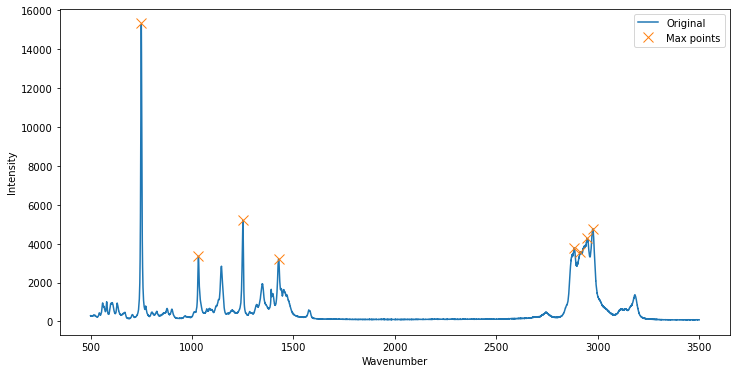

In [318]:
plt.figure(figsize=(12,6))
plt.plot(wavenumber, intensity, np.array(w_inter_max)[max_index],np.array(i_inter_max)[max_index],'x', ms = 10)
plt.xlabel("Wavenumber")
plt.ylabel("Intensity")
plt.legend(['Original', 'Max points'])
plt.show()

##### c) Produce a 'zoomed-in' figure for the 'regions of interest' corresponding to the four largest peaks. Plot the raw spectral data and overlay your interpolating function. Use a marker to show the wavenumber with maximal intensity.

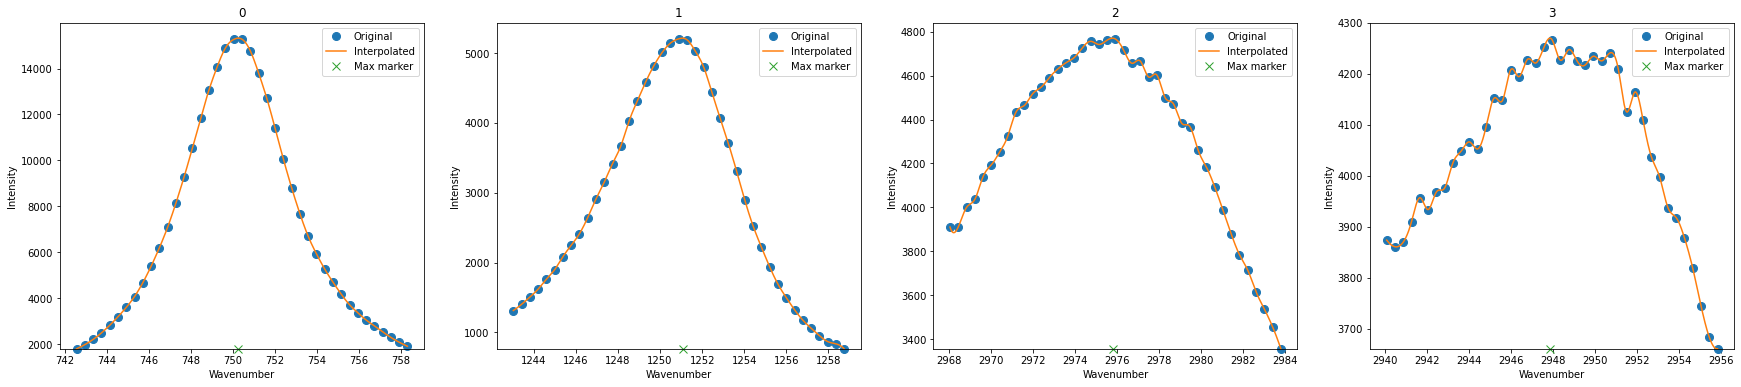

In [330]:
# Plot zoomed-in figure for the 4 largest ROI

num_subplot = 4
num_row = 1
num_col = 4

fig, axes = plt.subplots(num_row, num_col, figsize = (30,6))

for i in range(4):
    ax = axes[i]
    ax.plot(w_raw[max_index[i]],i_raw[max_index[i]],'o', w_inter[max_index[i]], i_inter[max_index[i]], w_inter_max[max_index[i]], min(i_inter[max_index[i]]),'x', ms=8, clip_on = False)
    ax.set_ylim(min(i_inter[max_index[i]]), )
    ax.set_xlabel('Wavenumber')
    ax.set_ylabel('Intensity')
    ax.legend(['Original','Interpolated','Max marker'])
    ax.set_title(f'{i}')

### 2. Unsupervised clustering algorithms

##### a) Use K-means clustering with 3-clusters to label each (x,y)

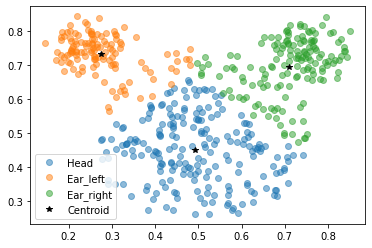

Predicted    0    1    2
Actual                  
Ear_left   100    0    0
Ear_right    0    0  100
Head        25  211   54


In [351]:
# Import libraries

from scipy.cluster.vq import kmeans2
import pandas as pd

# Read from cluster.txt

file_path = '/Users/woojaejeong/Desktop/Program/USC/Computational Introduction to Deep Learning/Homeworks/HW2/cluster.txt'
H = []; L = []; R = []

with open(file_path, "r") as file:
    for line in file:
        if 'Head' in line:
            H.append(line.split())

        if 'Ear_left' in line:
            L.append(line.split())

        if 'Ear_right' in line:
            R.append(line.split())

Head = []; Ear_left = []; Ear_right = []    # x,y values
id_H = []; id_l = []; id_r = []             # Index values (i.e., 'Head')

for i in range(1,len(H)):
    Head.append([float(H[i][0]), float(H[i][1])])
    id_H.append(H[i][2])

for i in range(1,len(R)):
    Ear_right.append([float(R[i][0]), float(R[i][1])])
    id_r.append(R[i][2])

for i in range(1,len(L)):
    Ear_left.append([float(L[i][0]), float(L[i][1])])
    id_l.append(L[i][2])

Head = np.array(Head); Ear_right = np.array(Ear_right); Ear_left = np.array(Ear_left)
id_H = np.array(id_H); id_l = np.array(id_l); id_r = np.array(id_r)

# Concatenate data
data = np.concatenate((Head, Ear_right, Ear_left))
idx = np.concatenate((id_H, id_r, id_l))

# Random shuffle data
indicies = np.arange(len(data))     # Index of the random shuffling
np.random.shuffle(indicies)

data_input = data[indicies]         # Random shuffled input (x,y)
data_label = idx[indicies]          # Random shuffled index

# K-means
centroid, label = kmeans2(data_input, 3, minit='points')

# Compute confusion matrix
confusion_matrix = pd.crosstab(data_label, label,rownames = ['Actual'], colnames = ['Predicted'])

# label_index for Q2)
label_index = np.array([" "," "," "])

# Compare the result in the confusion matrix and assign K-means resulting labels into 'Heads','Ear_right','Ear_left'
for i in range(3):
    if np.where(confusion_matrix[i] == max(confusion_matrix[i]))[0] == 0:
        el_class_k = data_input[label == i]
        label_index[i] = 'L'
    
    if np.where(confusion_matrix[i] == max(confusion_matrix[i]))[0] == 1:
        er_class_k = data_input[label == i]
        label_index[i] = 'R'

    if np.where(confusion_matrix[i] == max(confusion_matrix[i]))[0] == 2:
        h_class_k = data_input[label == i]
        label_index[i] = 'H'

# Plot results
plt.plot(h_class_k[:,0], h_class_k[:,1],'o',alpha=0.5,label='Head')
plt.plot(el_class_k[:,0],el_class_k[:,1],'o',alpha=0.5,label='Ear_left')
plt.plot(er_class_k[:,0],er_class_k[:,1],'o',alpha=0.5,label='Ear_right')
plt.plot(centroid[:,0], centroid[:,1], 'k*', label = 'centroids')
plt.legend(['Head','Ear_left','Ear_right','Centroid'])
plt.show()

print(confusion_matrix)

##### b) EM 

In [352]:
from scipy.stats import multivariate_normal as mvn
from numpy.core.umath_tests import matrix_multiply as mm

# Define EM algorithm

def em_gmm_vect(xs, pis, mus, sigmas, tol=0.0001, max_iter=1000):

    n, p = xs.shape
    k = len(pis)

    ll_old = 0
    ws_out = []

    for i in range(max_iter):
        exp_A = []
        exp_B = []
        ll_new = 0

        # E-step
        ws = np.zeros((k, n))
        
        for j in range(k):
            ws[j, :] = pis[j] * mvn(mus[j], sigmas[j]).pdf(xs)
        ws /= ws.sum(0)

        # M-step
        pis = ws.sum(axis=1)
        pis /= n

        mus = np.dot(ws, xs)
        mus /= ws.sum(1)[:, None]

        sigmas = np.zeros((k, p, p))
        for j in range(k):
            ys = xs - mus[j, :]
            sigmas[j] = (ws[j,:,None,None] * mm(ys[:,:,None], ys[:,None,:])).sum(axis=0)
        sigmas /= ws.sum(axis=1)[:,None,None]

        # update complete log likelihoood
        ll_new = 0
        for pi, mu, sigma in zip(pis, mus, sigmas):
            ll_new += pi*mvn(mu, sigma).pdf(xs)
        ll_new = np.log(ll_new).sum()

        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new

        ws_out.append(ws)

    ws_out = np.stack(ws_out, axis=2)        
    return ws, ws_out

# Initial input variable
xs = data_input

# Assign initial gamma using the results from (a)

init_gamma = []

for i in range(len(label)):
    if label_index[label[i]] == 'H':
        init_gamma.append([float(0),float(0),float(1)])

    if label_index[label[i]] == 'L':
        init_gamma.append([float(0),float(1),float(0)])

    if label_index[label[i]] == 'R':
        init_gamma.append([float(1),float(0),float(0)])

init_gamma = np.array(init_gamma).transpose()

n, p = xs.shape

# Assign initial weight value 
init_pis = init_gamma.sum(axis=1)
init_pis /= n

k = len(init_pis)

# Assign initial mean value
init_mu = np.dot(init_gamma, xs)
init_mu /= init_gamma.sum(1)[:, None]

# Assign initial sigma value
init_sigma = np.zeros((k,p,p))
for j in range(k):
    ys = xs - init_mu[j,:]
    init_sigma[j] = (init_gamma[j,:,None,None] * mm(ys[:,:,None], ys[:,None,:])).sum(axis=0)
init_sigma /= init_gamma.sum(axis=1)[:,None,None]

# Run EM
ws, ws_out = em_gmm_vect(xs, init_pis, init_mu, init_sigma)

##### 1) Plot of the final result 

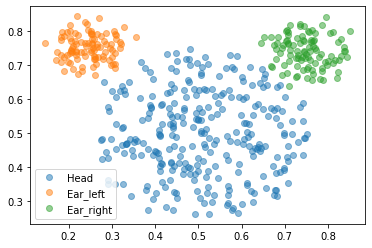

Predicted    0   1    2
Actual                 
Ear_left     0  99    1
Ear_right  100   0    0
Head         1   0  289


In [353]:
# Find class by the largest probability
idx = np.argmax(ws, axis=0)

el_class = data_input[idx == 1]    
er_class = data_input[idx == 0]
h_class = data_input[idx == 2]

plt.plot(h_class[:,0], h_class[:,1],'o',alpha=0.5,label='Head')
plt.plot(el_class[:,0],el_class[:,1],'o',alpha=0.5,label='Ear_left')
plt.plot(er_class[:,0],er_class[:,1],'o',alpha=0.5,label='Ear_right')
plt.legend(['Head','Ear_left','Ear_right'])
plt.show()

confusion_matrix = pd.crosstab(data_label, idx,rownames = ['Actual'], colnames = ['Predicted'])
print(confusion_matrix)

##### 2) Figures showing the class assignments during the first four iterations.

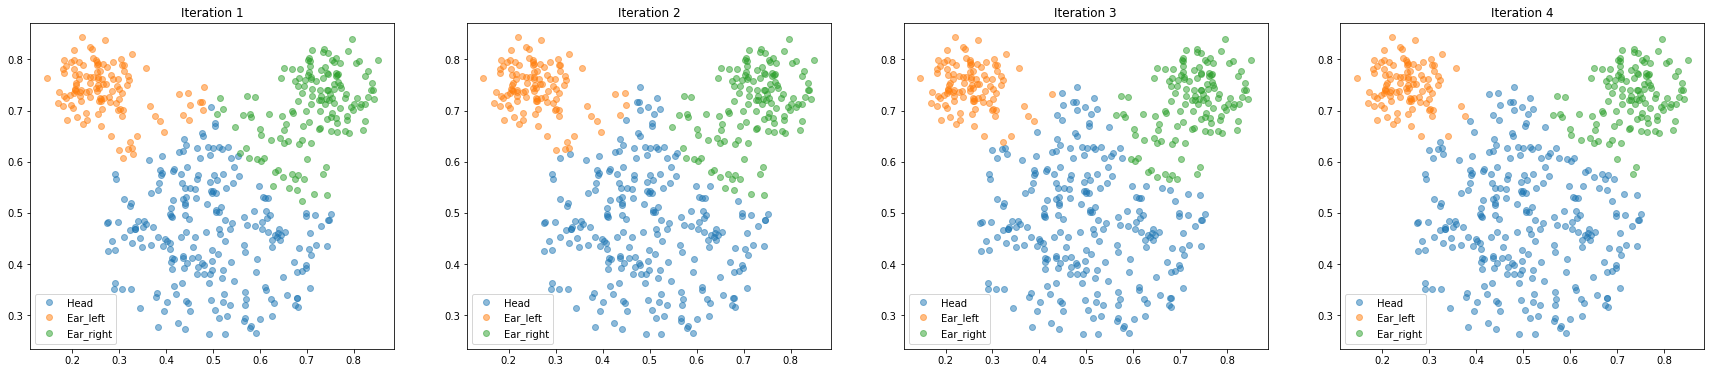

In [354]:
num_subplot = 4
num_row = 1
num_col = 4

fig, axes = plt.subplots(num_row, num_col, figsize = (30,6))

for i in range(4):
    ax = axes[i]

    idx = np.argmax(ws_out[:,:,i],axis=0)   # Class from the first 4 iterations
    el_class = data_input[idx == 1]    
    er_class = data_input[idx == 0]
    h_class = data_input[idx == 2]

    ax.plot(h_class[:,0], h_class[:,1],'o',alpha=0.5,label='Head')
    ax.plot(el_class[:,0],el_class[:,1],'o',alpha=0.5,label='Ear_left')
    ax.plot(er_class[:,0],er_class[:,1],'o',alpha=0.5,label='Ear_right')
    ax.legend(['Head','Ear_left','Ear_right'])
    ax.set_title(f'Iteration {i+1}')

##### 3) Comment on the difference between the clustering result in (a) and (b). Describe any obivous difference between the plots and indicate which performs better.

If you compare the result of K-means (bottom left) vs. EM (bottom right), you can see that the EM classification (clustering) performs better than K-means. The K-means method was able to cluster Ear_left and Ear_right correctly but was not able to completely distinguish Head clusters. Clustering using the EM algorithm was able to correctly cluster Heads as it iterates and converges.

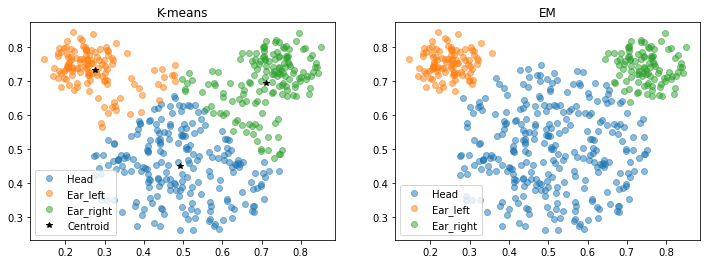

In [355]:
fig = plt.figure(figsize = (12,4))

x = fig.add_subplot(121)   # subplot
x.plot(h_class_k[:,0], h_class_k[:,1],'o',alpha=0.5,label='Head')
x.plot(el_class_k[:,0],el_class_k[:,1],'o',alpha=0.5,label='Ear_left')
x.plot(er_class_k[:,0],er_class_k[:,1],'o',alpha=0.5,label='Ear_right')
x.plot(centroid[:,0], centroid[:,1], 'k*', label = 'centroids')
plt.legend(['Head','Ear_left','Ear_right','Centroid'])
plt.title('K-means')

x = fig.add_subplot(122)   # subplot

idx = np.argmax(ws, axis=0)

el_class = data_input[idx == 1]    
er_class = data_input[idx == 0]
h_class = data_input[idx == 2]

x.plot(h_class[:,0], h_class[:,1],'o',alpha=0.5,label='Head')
x.plot(el_class[:,0],el_class[:,1],'o',alpha=0.5,label='Ear_left')
x.plot(er_class[:,0],er_class[:,1],'o',alpha=0.5,label='Ear_right')
plt.legend(['Head','Ear_left','Ear_right'])
plt.title('EM')
plt.show()